# Introdução


Exemplo de regressão linear múltipla.

Objetivo: estimar a figura de mérito ZT a partir de dados de propriedades físicas de materiais termoelétricos.

Neste exemplo, vamos trabalhar com um conjunto de dados de materiais termoelétricos. Materiais termoelétricos são aqueles que convertem energia térmica em energia elétrica, com base nos efeitos Seebeck e Peltier. Esses materiais possuem inúmeras aplicações tecnológicas como: coletores solares e sistemas de resfriamento termoelétrico.  A Teoria do Funcional da Densidade (Density Functional Theory, DFT) pode ser utilizada para descrever propriedades eletrônicas de materiais naturais ou sintéticos, além de investigar relações com propriedades físicas dos materiais, como a condutividade elétrica e a condutividade térmica. Porém, a aplicação da DFT tipicamente se limita a materiais de poucas células unitárias, devido aos altos custos computacionais. Técnicas de aprendizado de máquina podem ser utilizadas para investigar relações entre propriedades físicas de materiais, de modo a descobrir materiais que sejam mais eficientes para uma determinada aplicação tecnológica.  
Um índice muito utilizado para medir a eficiência de materiais termoelétricos na transformação de calor em energia elétrica é a figura de mérito (ZT), uma quantidade adimensional. A figura de mérito é calculada da seguinte forma:

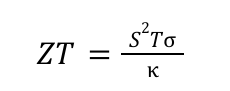


Onde S é o coeficiente de Seebeck, T é a temperatura absoluta, sigma é a condutividade elétrica e kapa é a condutividade térmica do material. Materiais termoelétricos eficientes são aqueles que apresentam ZT>1.
Base de dados: o conjunto de dados ESTM (experimentally synthesized thermoelectric materials) reúne dados experimentais de 880 materiais termoelétricos sintéticos, incluindo os seguintes atributos: composição química, coeficiente de Seebeck, condutividade elétrica, condutividade térmica, fator de poder e figura de mérito. Os dados estão disponíveis em https://github.com/KRICT-DATA/SIMD/tree/main/dataset.  
Referências:

Barua, N.K., Hall, E., Cheng, Y., Oliynyk, A.O. and Kleinke, H., 2024. Interpretable machine learning model on thermal conductivity using publicly available datasets and our internal lab dataset. Chemistry of Materials, 36(14), pp.7089-7100. https://doi.org/10.1021/acs.chemmater.4c01696

Na, G.S., Chang, H. A public database of thermoelectric materials and system-identified material representation for data-driven discovery. Comput Mater 8, 214 (2022). https://doi.org/10.1038/s41524-022-00897-2


Obs: o coeficiente de Seebeck, ou potência termoelétrica, mede a magnitude da tensão gerada em um material em resposta a uma diferença de temperatura, quantificando a eficiência da conversão de energia térmica em elétrica no efeito Seebeck. Ele pode ser negativo, dependendo do tipo de portadores de carga no material. Em materiais semicondutores e metais, portadores de carga positivos (buracos) levam a um coeficiente de Seebeck positivo, enquanto portadores de carga negativos (elétrons) resultam num coeficiente negativo.

In [1]:
# Importando as bibliotecas necessárias
import numpy as np # lidar com arrays
import pandas as pd # lidar com dataframes
import matplotlib.pyplot as plt # gráficos
import seaborn as sns # gráficos

In [2]:
# Leitura de arquivo armazenado no Google Drive
# Obs: o arquivo precisa ser compartilhado para leitura
# https://docs.google.com/spreadsheets/d/1cS9pX-TBklBQBEB3ZoFp6r27Zz-AH-ap/edit?usp=sharing&ouid=100045855553146048631&rtpof=true&sd=true
import gdown

# IDs dos arquivos no Google Drive
file = {
    'filename': 'estm.xlsx',
    'file_id': '1cS9pX-TBklBQBEB3ZoFp6r27Zz-AH-ap'
}

# Trazer o arquivo para a área de trabalho do colab
url = f"https://drive.google.com/uc?id={file['file_id']}"
print(f"Baixando {file['filename']}...")
gdown.download(url, file['filename'], quiet=False)
print(f"{file['filename']} baixado com sucesso!")

Baixando estm.xlsx...


Downloading...
From: https://drive.google.com/uc?id=1cS9pX-TBklBQBEB3ZoFp6r27Zz-AH-ap
To: /content/estm.xlsx
100%|██████████| 1.99M/1.99M [00:00<00:00, 106MB/s]

estm.xlsx baixado com sucesso!


In [3]:
# Leitura do arquivo
estm = pd.read_excel('estm.xlsx', header=1)
estm.head()

,Formula,temperature(K),seebeck_coefficient(μV/K),electrical_conductivity(S/m),thermal_conductivity(W/mK),power_factor(W/mK2),ZT,reference
0,BiSb(Se0.92Br0.08)3,300.0,-110.0,27766.0,0.63,0.000336,0.159985,10.1002/adfm.201806558
1,BiSb(Se0.92Br0.08)3,400.0,-138.0,23883.0,0.57,0.000455,0.319177,10.1002/adfm.201806558
2,BiSb(Se0.92Br0.08)3,500.0,-163.0,20850.0,0.53,0.000554,0.522607,10.1002/adfm.201806558
3,BiSb(Se0.92Br0.08)3,600.0,-181.0,19000.0,0.51,0.000622,0.732305,10.1002/adfm.201806558
4,BiSb(Se0.92Br0.08)3,700.0,-193.0,17925.0,0.50,0.000668,0.940000,10.1002/adfm.201806558


# Análise Exploratória

Já fizemos uma análise exploratória desse conjunto de dados em outra aula: https://colab.research.google.com/drive/1Lek92Oe8ZWU1W2mxQSg5dCPvka0uGP5h?usp=drive_link

Vamos focar nossa análise apenas no subconjunto de dados de materiais termoelétricos eficientes, que são aqueles que apresentam ZT>1.

In [4]:
# Subset dos materiais com ZT>1
df = estm[estm['ZT'] > 1].copy()
df.reset_index(drop=True, inplace=True)
df.drop(['Formula', 'reference'], axis=1, inplace=True) # selecionando apenas as variáveis numéricas
df.rename(columns={'temperature(K)':'T', 'seebeck_coefficient(μV/K)':'S',
                   'electrical_conductivity(S/m)':'sigma', 'thermal_conductivity(W/mK)':'k',
                   'power_factor(W/mK2)':'P'}, inplace=True)
df.head()

,T,S,sigma,k,P,ZT
0,800.0,-203.0,17340.0,0.440,0.000715,1.299207
1,800.0,-219.0,15479.0,0.440,0.000742,1.349797
2,800.0,-228.0,12500.0,0.450,0.000650,1.155200
3,800.0,-229.0,12128.0,0.480,0.000636,1.060007
4,698.0,-311.0,10860.0,0.705,0.001050,1.039961


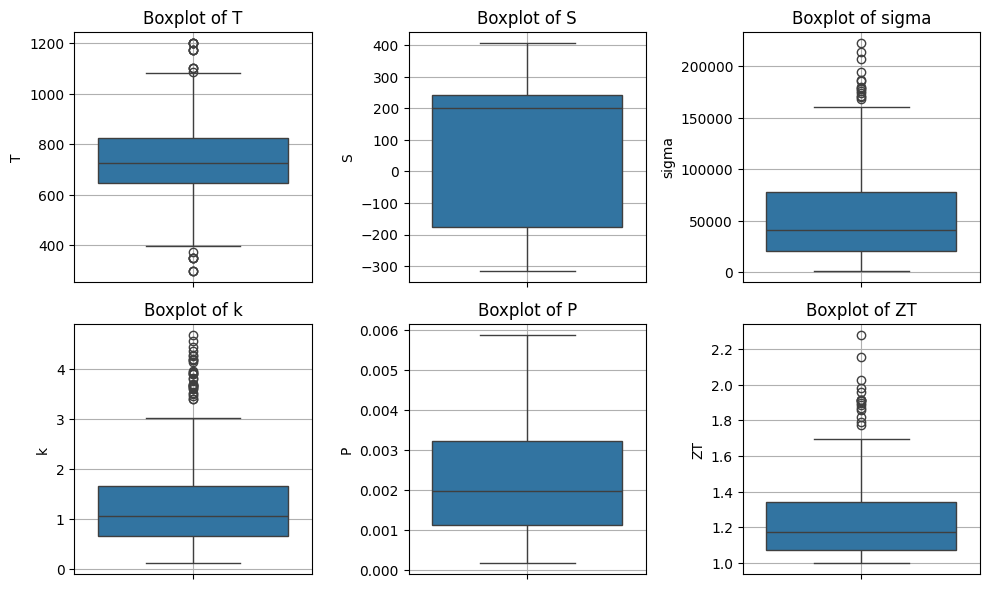

In [5]:
# Boxplot dos dados com ZT>1
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(df):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

Observe que a distribuição de S é bimodal, com um centro em valores positivos e outro centro em valores negativos. Para estimar ZT, o sinal de S não é importante, e traz uma distorção na relação entre eles. Convém utilizar S^2, ou então tomar o seu valor absoluto.

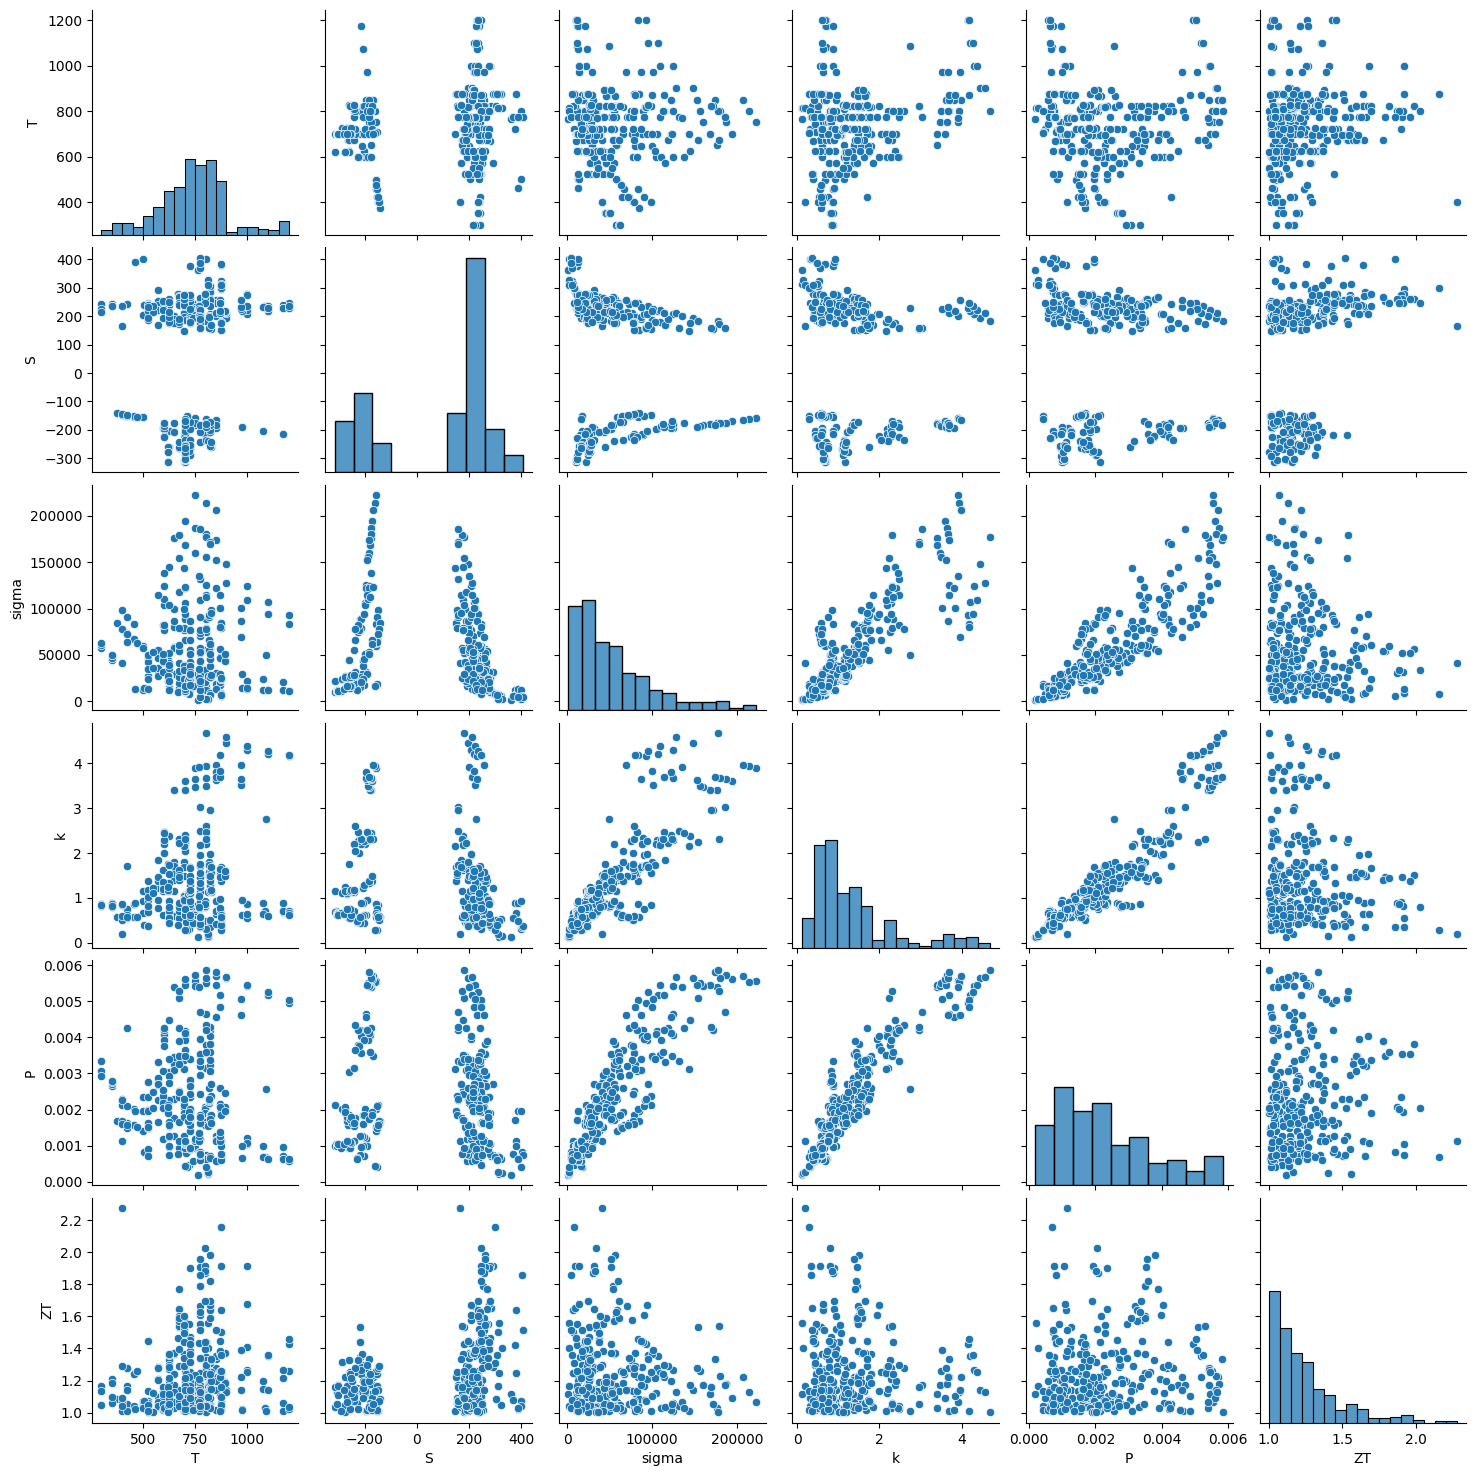

In [6]:
# Gráfico pairs
sns.pairplot(df)
plt.show()

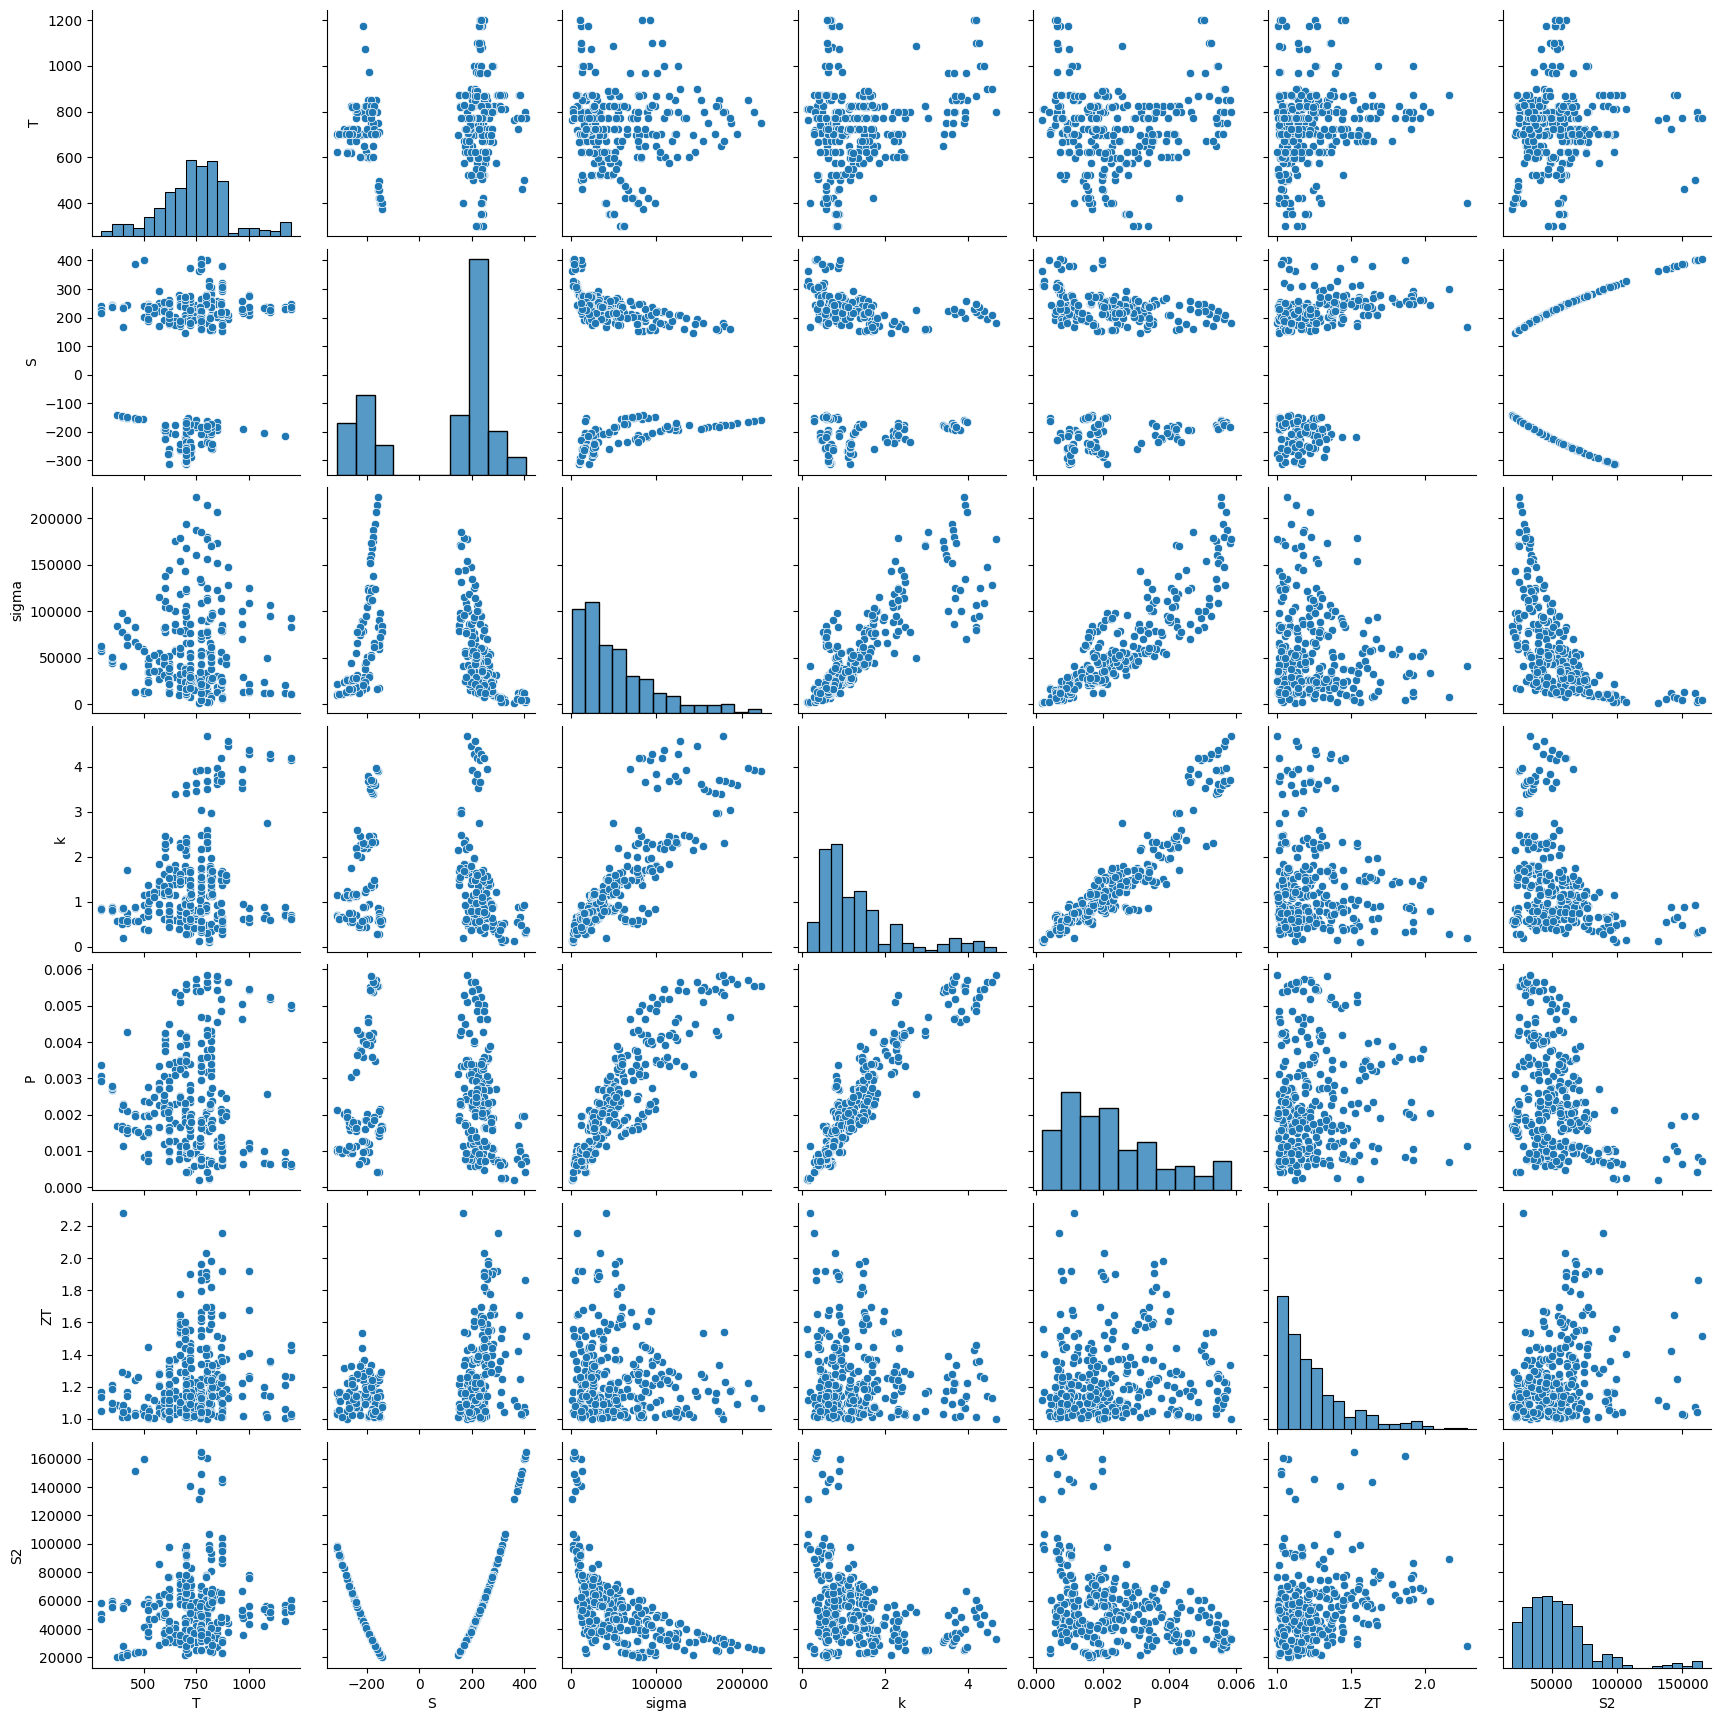

In [7]:
# Adicionando uma coluna com S^2
df['S2'] = df['S']**2
sns.pairplot(df)
plt.show()

Observe que ZT mostra uma correlação moderada com T, S, P e S2.

Observe também que as variáveis sigma, k e P são fortemente correlacionadas (colinearidade)

Exercício: calcular o p-value e verificar quais correlações são significativas.

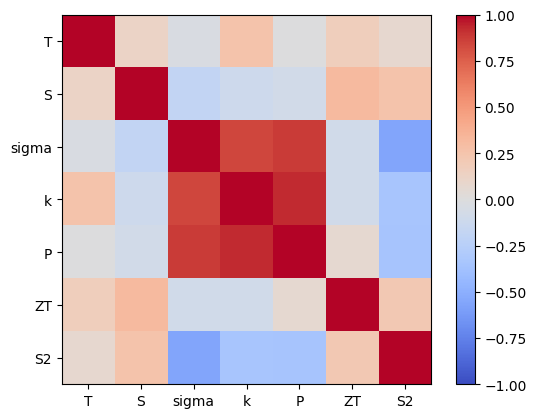

In [8]:
# Matriz de correlação
matrix = df.corr(method='pearson')
plt.imshow(matrix, cmap = 'coolwarm', vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(range(len(matrix.columns)), matrix.columns)
plt.yticks(range(len(matrix.columns)), matrix.columns)
plt.show()

# Preparação dos dados

In [9]:
# Separação de variáveis preditoras e alvo
X = df.drop(['ZT'], axis=1) # features
y = df.ZT # target

# Partição dos dados em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)

*Exercício: avalie mudanças no desempenho dos modelos para diferentes procedimentos de preparação de dados.*
*   *Utilizar outra estratégia de padronização ou normalização (MinMaxScaler, MaxAbsScaler)*
*   *Utilizar validação cruzada k-fold*










In [10]:
# Escalonando os preditores X
# Obs: use a função .inverse_transform se quiser reverter a transformação
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Regressão linear múltipla

### Modelo S

Modelo com todos os preditores utilizando S original

In [11]:
# Modelo com todos os preditores usando S original

# Exclui 'S2'
column_exclude = ['S2']
column_indices = [list(X.columns).index(col) for col in column_exclude]
X_train_s_subset = np.delete(X_train_s, column_indices, axis=1)
X_test_s_subset = np.delete(X_test_s, column_indices, axis=1)

from sklearn import linear_model
regr = linear_model.LinearRegression() # Create regressor
regr.fit(X_train_s_subset, y_train) # Train regressor

y_pred_train = regr.predict(X_train_s_subset) # predição para o conjunto de treino
y_pred_test = regr.predict(X_test_s_subset) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_train_s_subset, y_train)) # Coefficient of determination R^2

Intercepto: 0.6832721811214297
Coeficientes: [ 0.81768222  0.11170105 -0.37151062 -2.2226936   2.16722852]
R^2 =  0.5707537424953455


Observe que k e P, que são correlacionados entre si, apresentaram coeficientes com alta magnitude e sinais opostos. Temos um problema de colinearidade no modelo.

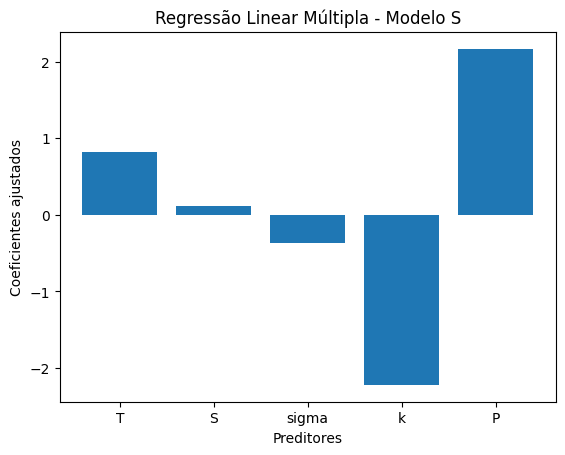

In [12]:
# Gráfico dos coeficientes ajustados
nomes = X.columns.drop(column_exclude)
coef = regr.coef_
ax = plt.bar(np.arange(len(coef)), coef)
plt.xticks(ticks=np.arange(len(coef)), labels=nomes) # Use set_xticks and set_xticklabels on the axes object
plt.xlabel("Preditores")
plt.ylabel("Coeficientes ajustados")
plt.title("Regressão Linear Múltipla - Modelo S")
plt.show()

Comparando as métricas de desempenho nos conjuntos de treino e teste, podemos avaliar se houve overfitting ou não.

Neste caso, as métricas pioraram muito no conjunto de teste. O que isso significa?

In [13]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão linear múltipla - 5 preditores')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão linear múltipla - 5 preditores
Desempenho no conjunto de treino
R^2 =  0.5707537424953455
MSE =  0.02289192564001705
MAE =  0.10618675662875567
Desempenho no conjunto de teste
R^2 =  0.24724690950942563
MSE =  0.04417421593722483
MAE =  0.12931595251274858


A biblioteca stasmodels fornece um relatório com diversas métricas de qualidade do ajuste, bem como os coeficientes ajustados, sua margem de erro e significância estatística.

In [14]:
# Modelo com todos os preditores - statsmodels
import statsmodels.api as sm
X_train_sm = sm.add_constant(X_train_s_subset) # adicionar uma coluna constante para o statsmodels ajustar um itercepto
mod = sm.OLS(y_train, X_train_sm) # ajustar o modelo
regsm = mod.fit()
print(regsm.summary())

                            OLS Regression Results                            
Dep. Variable:                     ZT   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     65.95
Date:                Fri, 26 Sep 2025   Prob (F-statistic):           1.31e-43
Time:                        14:49:19   Log-Likelihood:                 119.26
No. Observations:                 254   AIC:                            -226.5
Df Residuals:                     248   BIC:                            -205.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6833      0.043     15.826      0.0

Avaliando os resíduos no conjunto de treino.

Observe que há uma estrutura, sendo que o resíduo aumenta com o valor de ZT.

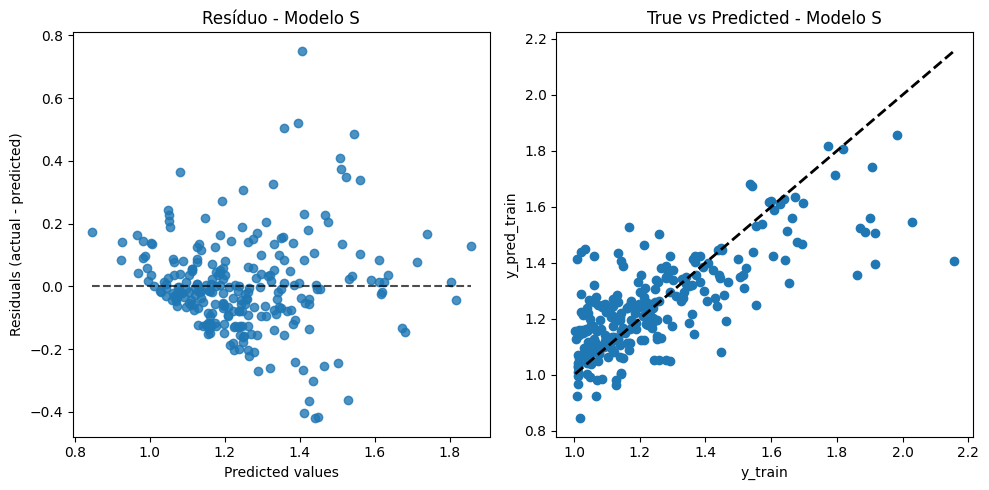

In [15]:
# Gráfico dos resíduos para o conjunto de treinamento
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0]) # Plot on the first axes
ax[0].set_title('Resíduo - Modelo S')

ax[1].scatter(y_train, y_pred_train)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted - Modelo S')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

### Modelo S2

Modelo com todos os preditores utilizando S^2

In [16]:
# Modelo com todos os preditores usando S^2

# Exclui 'S'
column_exclude = ['S']
column_indices = [list(X.columns).index(col) for col in column_exclude]
X_train_s_subset = np.delete(X_train_s, column_indices, axis=1)
X_test_s_subset = np.delete(X_test_s, column_indices, axis=1)

from sklearn import linear_model
regr = linear_model.LinearRegression() # Create regressor
regr.fit(X_train_s_subset, y_train) # Train regressor

y_pred_train = regr.predict(X_train_s_subset) # predição para o conjunto de treino
y_pred_test = regr.predict(X_test_s_subset) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_train_s_subset, y_train)) # Coefficient of determination R^2

Intercepto: 0.6679800860686473
Coeficientes: [ 0.8672978  -0.27211585 -2.31514899  2.20474922  0.17325362]
R^2 =  0.5640993816750126


Observe que k e P, que são correlacionados entre si, apresentaram coeficientes com alta magnitude e sinais opostos. Temos um problema de colinearidade no modelo.

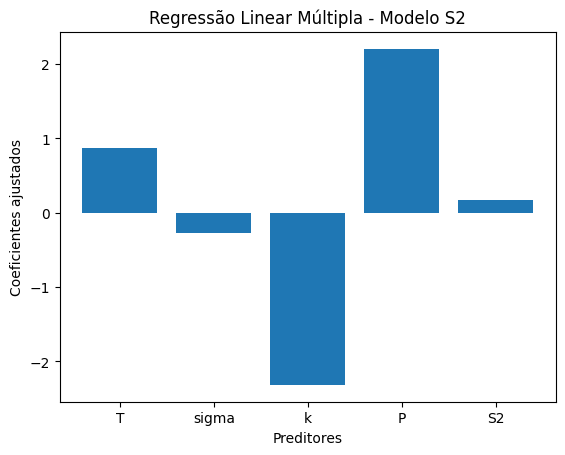

In [17]:
# Gráfico dos coeficientes ajustados
nomes = X.columns.drop(column_exclude)
coef = regr.coef_
ax = plt.bar(np.arange(len(coef)), coef)
plt.xticks(ticks=np.arange(len(coef)), labels=nomes) # Use set_xticks and set_xticklabels on the axes object
plt.xlabel("Preditores")
plt.ylabel("Coeficientes ajustados")
plt.title("Regressão Linear Múltipla - Modelo S2")
plt.show()

In [18]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão linear múltipla - 5 preditores')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão linear múltipla - 5 preditores
Desempenho no conjunto de treino
R^2 =  0.5640993816750126
MSE =  0.02324680615538008
MAE =  0.10999263271962312
Desempenho no conjunto de teste
R^2 =  0.23470149180033473
MSE =  0.044910425456528034
MAE =  0.1292572858558354


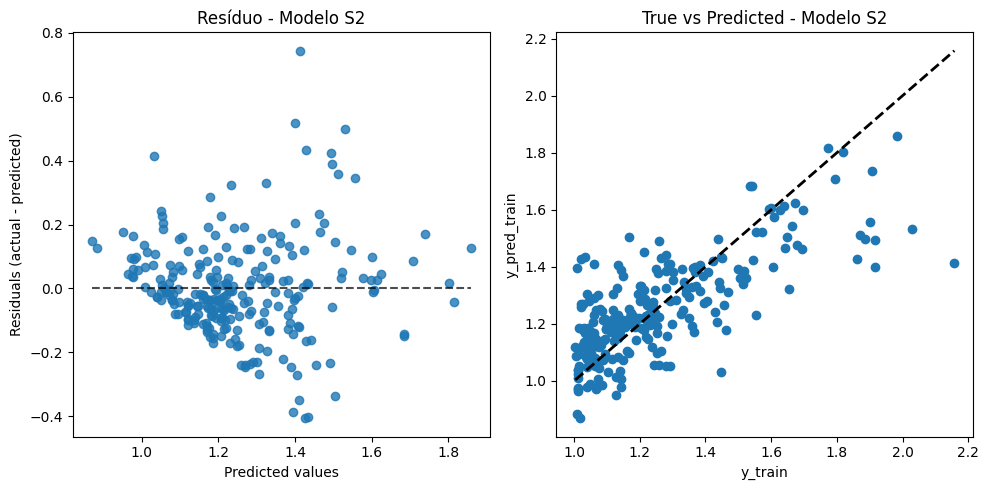

In [19]:
# Gráfico dos resíduos para o conjunto de treinamento
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0]) # Plot on the first axes
ax[0].set_title('Resíduo - Modelo S2')

ax[1].scatter(y_train, y_pred_train)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted - Modelo S2')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout() # Adjust layout to prevent overlapping titles
plt.show()

### Modelo 3 preditores

*Exercício: construa um modelo linear eliminando a colinearidade entre os preditores. Teste diferentes conjuntos de preditores. Avalie as mudanças no desempenho do modelo.*

In [20]:
# Modelo com 3 preditores: T, S2 e P

# Exclui 'S', 'sigma' e 'k'
column_exclude = ['S','sigma','k']
column_indices = [list(X.columns).index(col) for col in column_exclude]
X_train_s_subset = np.delete(X_train_s, column_indices, axis=1)
X_test_s_subset = np.delete(X_test_s, column_indices, axis=1)

from sklearn import linear_model
regr = linear_model.LinearRegression() # Create regressor
regr.fit(X_train_s_subset, y_train) # Train regressor

y_pred_train = regr.predict(X_train_s_subset) # predição para o conjunto de treino
y_pred_test = regr.predict(X_test_s_subset) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_train_s_subset, y_train)) # Coefficient of determination R^2

Intercepto: 1.0073793415548962
Coeficientes: [0.17445102 0.173141   0.38342167]
R^2 =  0.11561567294046549


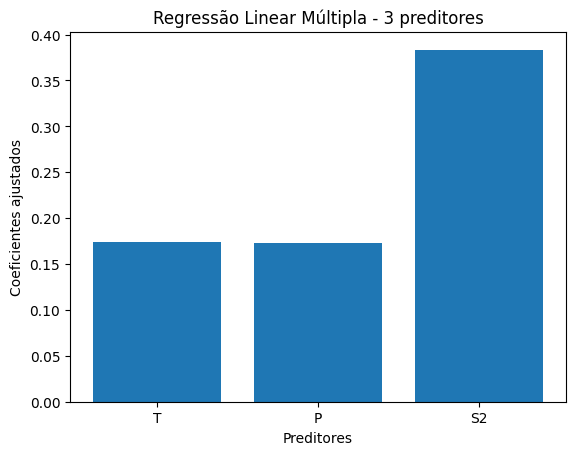

In [21]:
# Gráfico dos coeficientes ajustados
nomes = X.columns.drop(column_exclude)
coef = regr.coef_
ax = plt.bar(np.arange(len(coef)), coef)
plt.xticks(ticks=np.arange(len(coef)), labels=nomes)
plt.xlabel("Preditores")
plt.ylabel("Coeficientes ajustados")
plt.title("Regressão Linear Múltipla - 3 preditores")
plt.show()

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão linear múltipla - 3 preditores')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão linear múltipla - 3 preditores
Desempenho no conjunto de treino
R^2 =  0.11561567294046549
MSE =  0.04716467505141581
MAE =  0.16456705967648017
Desempenho no conjunto de teste
R^2 =  -0.02484338594674851
MSE =  0.06014143761687443
MAE =  0.16595071606969927


Persiste a estrutura no resíduo, e o desempenho do modelo piorou muito com 3 preditores.

O modelo superestima ZT baixo e subestima ZT alto.

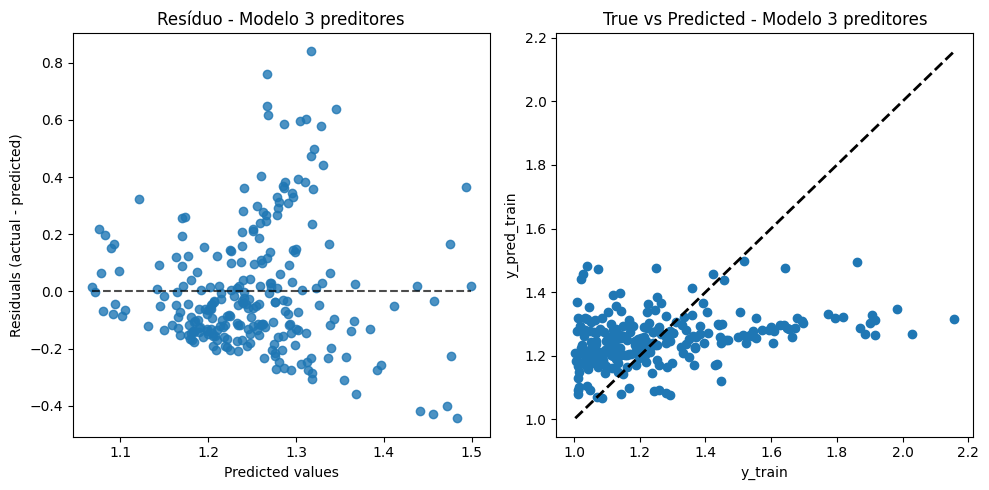

In [23]:
# Gráfico dos resíduos para o conjunto de treinamento
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0])
ax[0].set_title('Resíduo - Modelo 3 preditores')

ax[1].scatter(y_train, y_pred_train)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted - Modelo 3 preditores')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()

# Regressão Lasso (L1)

Vamos aplicar uma penalidade do tipo L1 com lambda = 0.0025.






*Exercício: Variar o valor de lambda (alpha) e avaliar os impactos nos coeficientes e no valor de R^2. Também é possível usar a busca em grade (Grid Search) para obter o valor de lambda que maximiza o R^2 ou outra métrica de interesse.*

In [24]:
column_exclude = ['S']
column_indices = [list(X.columns).index(col) for col in column_exclude]
X_train_s_subset = np.delete(X_train_s, column_indices, axis=1)
X_test_s_subset = np.delete(X_test_s, column_indices, axis=1)

from sklearn.linear_model import Lasso
a = 0.0025
lassoReg = Lasso(alpha=a)
lassoReg.fit(X_train_s_subset, y_train)
y_pred_train = lassoReg.predict(X_train_s_subset) # predição para o conjunto de treino
y_pred_test = lassoReg.predict(X_test_s_subset) # predição para o conjunto de teste

print('Intercepto:', lassoReg.intercept_)
nomes = X.columns.drop(column_exclude)
print(nomes)
print('Coeficientes:', lassoReg.coef_)
print('R^2 = ', lassoReg.score(X_train_s_subset,y_train))

Intercepto: 0.908147587077341
Index(['T', 'sigma', 'k', 'P', 'S2'], dtype='object')
Coeficientes: [ 0.45082411 -0.         -1.13765169  1.02398729  0.22624811]
R^2 =  0.42428726042444265


A regressão Lasso com alpha=0.0025 removeu um dos preditores correlacionados (sigma).

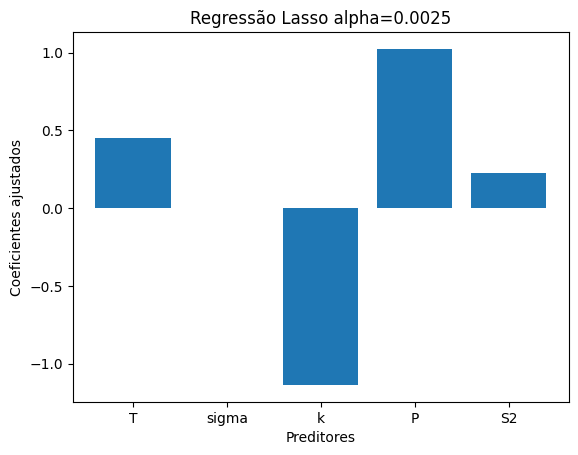

In [25]:
# Gráfico dos coeficientes ajustados
nomes = X.columns.drop(column_exclude)
coef = lassoReg.coef_
ax = plt.bar(np.arange(len(coef)), coef)
plt.xticks(ticks=np.arange(len(coef)), labels=nomes)
plt.xlabel("Preditores")
plt.ylabel("Coeficientes ajustados")
plt.title(f"Regressão Lasso alpha={a}")
plt.show()

In [26]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão Lasso')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão Lasso
Desempenho no conjunto de treino
R^2 =  0.42428726042444265
MSE =  0.030703059127385062
MAE =  0.13115644181597222
Desempenho no conjunto de teste
R^2 =  0.20705003388381804
MSE =  0.04653311088740052
MAE =  0.14211758442606648


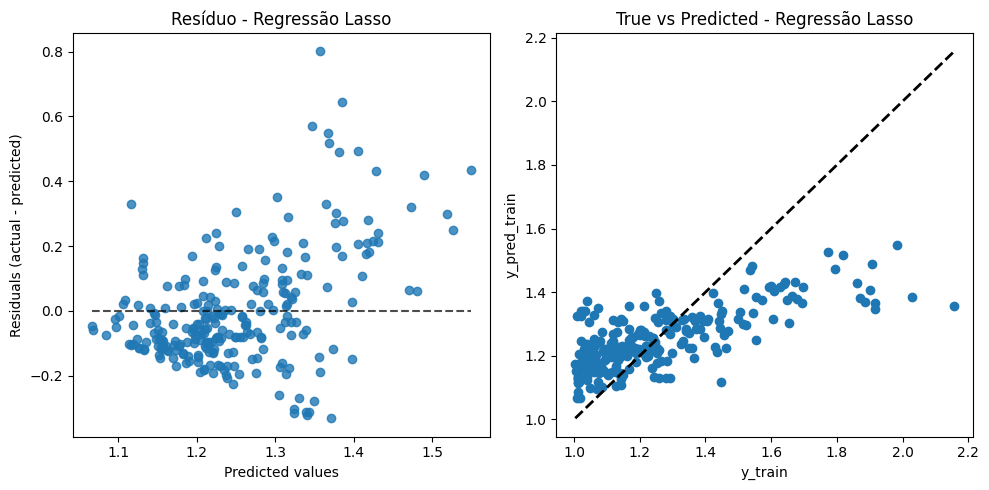

In [27]:
# Gráfico dos resíduos para o conjunto de treinamento
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0])
ax[0].set_title('Resíduo - Regressão Lasso')

ax[1].scatter(y_train, y_pred_train)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted - Regressão Lasso')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()

# Regressão Ridge (L2)

In [28]:
column_exclude = ['S']
column_indices = [list(X.columns).index(col) for col in column_exclude]
X_train_s_subset = np.delete(X_train_s, column_indices, axis=1)
X_test_s_subset = np.delete(X_test_s, column_indices, axis=1)

from sklearn.linear_model import Ridge
a = 0.5
ridgeReg = Ridge(alpha=a)
ridgeReg.fit(X_train_s_subset,y_train)

y_pred_train = ridgeReg.predict(X_train_s_subset) # predição para o conjunto de treino
y_pred_test = ridgeReg.predict(X_test_s_subset) # predição para o conjunto de teste

print('Intercepto:', ridgeReg.intercept_)
nomes = X.columns.drop(column_exclude)
print(nomes)
print('Coeficientes:', ridgeReg.coef_)
print('R^2 = ', ridgeReg.score(X_train_s_subset,y_train))

Intercepto: 0.8737105427376101
Index(['T', 'sigma', 'k', 'P', 'S2'], dtype='object')
Coeficientes: [ 0.50687509 -0.19230625 -1.21632906  1.22501134  0.22505274]
R^2 =  0.46358609484142965


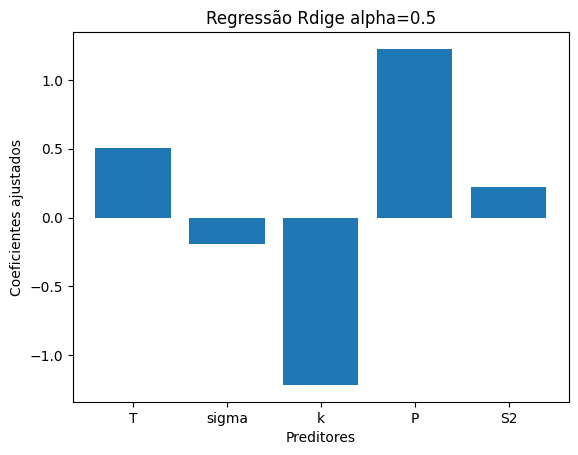

In [29]:
# Gráfico dos coeficientes ajustados
nomes = X.columns.drop(column_exclude)
coef = ridgeReg.coef_
ax = plt.bar(np.arange(len(coef)), coef)
plt.xticks(ticks=np.arange(len(coef)), labels=nomes)
plt.xlabel("Preditores")
plt.ylabel("Coeficientes ajustados")
plt.title(f"Regressão Rdige alpha={a}")
plt.show()

In [30]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão Ridge')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

Regressão Ridge
Desempenho no conjunto de treino
R^2 =  0.46358609484142965
MSE =  0.028607231896548332
MAE =  0.12560912347989767
Desempenho no conjunto de teste
R^2 =  0.20887951306618613
MSE =  0.04642575057300856
MAE =  0.13870553416598663


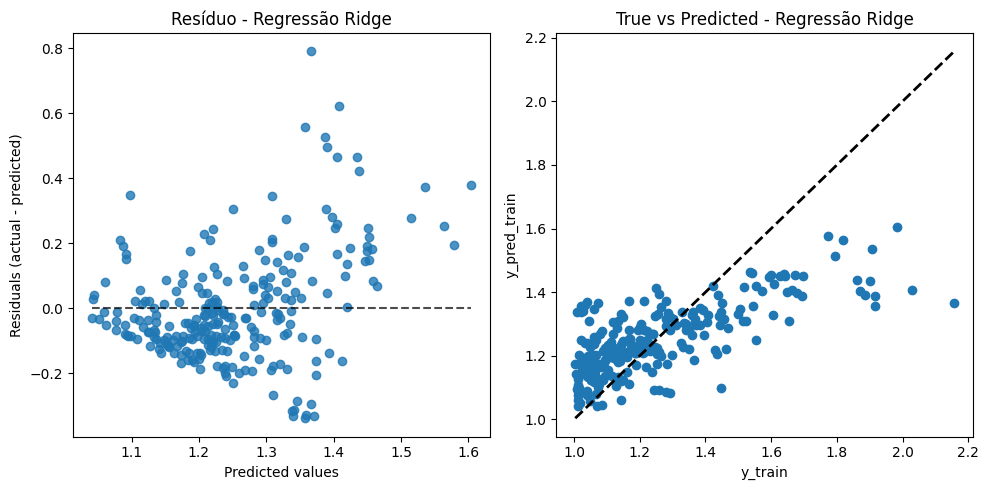

In [31]:
# Gráfico dos resíduos para o conjunto de treinamento
from sklearn.metrics import PredictionErrorDisplay

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plotresid = PredictionErrorDisplay(y_true=y_train, y_pred=y_pred_train)
plotresid.plot(ax=ax[0])
ax[0].set_title('Resíduo - Regressão Ridge')

ax[1].scatter(y_train, y_pred_train)
ax[1].set_xlabel('y_train')
ax[1].set_ylabel('y_pred_train')
ax[1].set_title('True vs Predicted - Regressão Ridge')
# Add a 1:1 dashed line
ax[1].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()

# Conclusão

*Compare os diferentes modelos testados.*